## PPDS Homework 3
Jack (Quan Cheng) Xie | N14077607 | qcx201 <br>
Professor Panos Ipeirotis <br>
2 April 2018 <br>

The webpage I am crawling is https://www.govtrack.us/misconduct, which compiles misconduct allegations against congress members from 1789 to the present. <br>

Each webpage entry includes the congress member (name, disctrict, period in office), a link to the member's page, a paragraph summary of the misconduct, and a timeline of the investigation of allegations. <br>

This is one of the data sources we are considering for our project on providing information about politicians.

In [118]:
import requests
from lxml import html
import pandas as pd
import re

url = "https://www.govtrack.us/misconduct"
gt_url = 'https://www.govtrack.us'
response = requests.get(url)
doc = html.fromstring(response.text)

In [119]:
print(doc.xpath('//h1')[0].text_content())
print(url)

Congressional Misconduct Database
https://www.govtrack.us/misconduct


### 1. Website Scraping Using Regex and Xpath

In [120]:
# Using Regex to get entry class names
html = requests.get(url).text

regex = re.compile(r'class="misconduct-entry.*"')
matches = regex.finditer(html)
calls = [m.group() for m in matches]

entries = [doc.xpath('//div[@{ent}]'.format(
    ent=call))[0] for call in calls]

In [121]:
# Note calls are not unique
print('Total calls:',len(calls),
      '\nUnique calls:',len(set(calls)))

Total calls: 383 
Unique calls: 70


In [127]:
def parseEntryNode(entry):

    member = entry.xpath('.//h3/a')[0].text_content().strip()

    member_page = gt_url+entry.xpath('.//h3/a')[0].get('href')
    
    tags = [tag.text_content().strip()
            for tag in entry.xpath('.//div[@class="tag-list"]')[0]]

    paragraph = entry.xpath('.//p')[0].text_content()

    updates = [' '.join(update.text_content().split())
               for update in entry.xpath('.//table')[0]]

    update_links = [update.xpath('.//a')[0].get('href')
                    if len(update.xpath('.//a')) > 0
                    else None
            for update in entry.xpath('.//table')[0]]
    
    result = {
    'member' : member,
    'member_page' : member_page,
    'tags' : tags,
    'paragraph' : paragraph,
    'updates' : updates,
    'update_links' : update_links
    }
    
    return result

In [ ]:
contents = doc.xpath('//div[@class="col-sm-8 col-sm-pull-4"]')[0]
data = [parseEntryNode(entry) for entry in entries]
df = pd.DataFrame(data)

In [126]:
# Print duplicates
print('Duplicate Rows:', len(df[df['paragraph'].duplicated()]))

Duplicate Rows: 313


In [12]:
# Set index (counting from oldest) to use as primary key in SQL
df['entry_index'] = len(df)-df.index

In [54]:
# Preview the dataframe
df.head(3)

,member,member_page,paragraph,tags,update_links,updates,entry_index,member_name,district,party
0,Rep. Paul Gosar [R-AZ4],https://www.govtrack.us/congress/members/paul_...,"In February 2018, a resolution to reprimand Re...","[ethics violation, resolved]",[https://twitter.com/RepGosar/status/958407946...,"[Jan. 30, 2018 Asked Capitol Police to arrest ...",383,Rep. Paul Gosar,[R-AZ4],Republican
1,Rep. Elizabeth Esty [D-CT5],https://www.govtrack.us/congress/members/eliza...,"In April of 2018, Rep. Esty announced she woul...","[sexual harassment & abuse, unresolved]",[https://www.nytimes.com/2018/04/02/us/politic...,"[Apr. 2, 2018 Esty announced she would not see...",382,Rep. Elizabeth Esty,[D-CT5],Democrat
2,Rep. Devin Nunes [R-CA22],https://www.govtrack.us/congress/members/devin...,"In 2018, the Federal Elections Commission (FEC...","[campaign & elections, unresolved]",[http://docquery.fec.gov/pdf/285/2018032003000...,"[Mar. 20, 2018 Federal Elections Commission se...",381,Rep. Devin Nunes,[R-CA22],Republican


#### Scraping Alternative
The parsing method using Regex above produces duplicates because of the html structure that has the same calls. Below is a method that of iterative indexing to get the data.

In [128]:
contents = doc.xpath('//div[@class="col-sm-8 col-sm-pull-4"]')[0]
# Data contants starts from index 1
data = [parseEntryNode(contents[i]) for i in range(1,len(contents))] 
df = pd.DataFrame(data)

In [129]:
def get_bioguide(member_url):
    '''returns bioguide given govtrack member page'''
    member_html = requests.get(member_url).text
    bioregex = re.compile(r'href="http://bioguide.congress.gov/.*" ')
    res = bioregex.findall(member_html)[0]
    bioguide = res.replace(
        'href="http://bioguide.congress.gov/scripts/biodisplay.pl?index=','')[:7]
    return bioguide
bioguide = [get_bioguide(url) for url in df['member_page']]
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [130]:
df['bioguide'] = bioguide

In [131]:
# Print duplicates
print('Duplicate rows:', len(df[df['paragraph'].duplicated()]))

Duplicate rows: 0


In [132]:
# Reverse entry_index for primary key
df['entry_index'] = len(df)-df.index

In [133]:
# Preview the dataframe
df.head(3)

,member,member_page,paragraph,tags,update_links,updates,bioguide,entry_index
0,Rep. Paul Gosar [R-AZ4],https://www.govtrack.us/congress/members/paul_...,"In February 2018, a resolution to reprimand Re...","[ethics violation, resolved]",[https://twitter.com/RepGosar/status/958407946...,"[Jan. 30, 2018 Asked Capitol Police to arrest ...",G000565,383
1,Rep. Elizabeth Esty [D-CT5],https://www.govtrack.us/congress/members/eliza...,"In April of 2018, Rep. Esty announced she woul...","[sexual harassment & abuse, unresolved]",[https://www.nytimes.com/2018/04/02/us/politic...,"[Apr. 2, 2018 Esty announced she would not see...",E000293,382
2,Rep. Devin Nunes [R-CA22],https://www.govtrack.us/congress/members/devin...,"In 2018, the Federal Elections Commission (FEC...","[campaign & elections, unresolved]",[http://docquery.fec.gov/pdf/285/2018032003000...,"[Mar. 20, 2018 Federal Elections Commission se...",N000181,381


In [134]:
# Get names and districts of congress members using Regex
# raw string for member column
members_strings = df['member'].to_string()

# The district regex is imperfect because of irregularities
district_regex = re.compile(r'\[+\w-[\w]*')
district_matches = district_regex.finditer(members_strings)
rg_district = [m.group()[1:] for m in district_matches]

# Get names using regex
names_regex = re.compile(r"[A-z].*\[")
names_matches = names_regex.finditer(members_strings)
names = [m.group()[:-2] for m in names_matches]

df['member_name'] = names

# Get districts from names
district = [df['member'][i].replace(
    df['member_name'][i]+' ','')
            for i in range(len(df))]

df['district'] = district

In [135]:
# Because of irregularities in district format, regex misses some results
print('regex results:',len(rg_district),
      '\ndistrict list results:',len(district),
      '\ndf length:',len(df))

regex results: 381 
district list results: 383 
df length: 383


In [136]:
# Member parties are denoted by 1 letter abbreviations before the district
print(set(df['district'].str[1:3]))

{'A-', 'D-', 'J-', 'F-', 'R-', 'U-', 'R,', 'I-', 'W-'}


In [137]:
# Add column with full party name
party_dict = {'A':'A (Miscellaneous)','D':'Democrat','F':'Federalist',
         'I':'Independent','J':'Jackson','R':'Republican',
         'U' : 'Unconditional Unionist','W' :'Whig'}

member_party = [party_dict[df['district'].iloc[i][1]] for i in range(len(df))]

df['party'] = member_party

In [138]:
# Let's see the result of our data cleaning
df[['member','member_name','district','party']].head()

,member,member_name,district,party
0,Rep. Paul Gosar [R-AZ4],Rep. Paul Gosar,[R-AZ4],Republican
1,Rep. Elizabeth Esty [D-CT5],Rep. Elizabeth Esty,[D-CT5],Democrat
2,Rep. Devin Nunes [R-CA22],Rep. Devin Nunes,[R-CA22],Republican
3,Rep. Robert Brady [D-PA1],Rep. Robert Brady,[D-PA1],Democrat
4,Rep. Patrick Meehan [R-PA7],Rep. Patrick Meehan,[R-PA7],Republican


In [163]:
df.head()

,member,member_page,paragraph,tags,update_links,updates,bioguide,entry_index,member_name,district,party
0,Rep. Paul Gosar [R-AZ4],https://www.govtrack.us/congress/members/paul_...,"In February 2018, a resolution to reprimand Re...","[ethics violation, resolved]",[https://twitter.com/RepGosar/status/958407946...,"[Jan. 30, 2018 Asked Capitol Police to arrest ...",G000565,383,Rep. Paul Gosar,[R-AZ4],Republican
1,Rep. Elizabeth Esty [D-CT5],https://www.govtrack.us/congress/members/eliza...,"In April of 2018, Rep. Esty announced she woul...","[sexual harassment & abuse, unresolved]",[https://www.nytimes.com/2018/04/02/us/politic...,"[Apr. 2, 2018 Esty announced she would not see...",E000293,382,Rep. Elizabeth Esty,[D-CT5],Democrat
2,Rep. Devin Nunes [R-CA22],https://www.govtrack.us/congress/members/devin...,"In 2018, the Federal Elections Commission (FEC...","[campaign & elections, unresolved]",[http://docquery.fec.gov/pdf/285/2018032003000...,"[Mar. 20, 2018 Federal Elections Commission se...",N000181,381,Rep. Devin Nunes,[R-CA22],Republican
3,Rep. Robert Brady [D-PA1],https://www.govtrack.us/congress/members/rober...,Brady faced an allegation of leading a crimina...,"[bribery & corruption, campaign & elections, u...",[http://www.philly.com/philly/news/pennsylvani...,"[Nov. 1, 2017 Federal Bureau of Investigation ...",B001227,380,Rep. Robert Brady,[D-PA1],Democrat
4,Rep. Patrick Meehan [R-PA7],https://www.govtrack.us/congress/members/patri...,While serving on the House Committee on Ethics...,"[sexual harassment & abuse, unresolved]",[https://www.nytimes.com/2018/01/20/us/politic...,"[Jan. 20, 2018 House of Representatives remove...",M001181,379,Rep. Patrick Meehan,[R-PA7],Republican


### Creating SQL Database and Tables

In [139]:
from sqlalchemy import create_engine
from IPython.display import clear_output as clear

conn_string = 'mysql://{user}:{password}@{host}:{port}/?charset=utf8'.format(
    user     = 'root', 
    password = input('password'), 
    host     = '127.0.0.01', 
    port     = 3306, 
    encoding = 'utf-8'
)

clear()

pw = 'dwdstudent2015'
engine = create_engine(conn_string)

In [140]:
engine.execute('CREATE DATABASE IF NOT EXISTS congressional_misconduct')

/anaconda/lib/python3.6/site-packages/sqlalchemy/engine/default.py:507: Warning: (1007, "Can't create database 'congressional_misconduct'; database exists")
  cursor.execute(statement, parameters)


In [141]:
engine.execute('USE congressional_misconduct')
pd.read_sql('SHOW Databases',con=engine)

,Database
0,information_schema
1,congressional_misconduct
2,mysql
3,performance_schema
4,portfolio_analysis
5,sys


In [142]:
engine.execute('USE congressional_misconduct')

In [164]:
# Drop all existing tables
db_tables = pd.read_sql('SHOW TABLES',con=engine).iloc[:,0]

for t in db_tables:
    if t != 'misconduct_entries':
        engine.execute('DROP TABLE IF EXISTS {table}'.format(table = t))
# Drop table with foreign key reference last        
engine.execute('DROP TABLE IF EXISTS {table}'.format(table = 'misconduct_entries'))

In [165]:
db_tables

0    misconduct_entries
1       misconduct_tags
2       timeline_update
Name: Tables_in_congressional_misconduct, dtype: object

In [166]:
df[['entry_index','member_name','bioguide','party','district',
    'member','member_page','paragraph']].to_sql(name='misconduct_entries',
                                                 con=engine,
                                                 if_exists='replace',
                                                 index=False)

add_key_query = 'ALTER TABLE misconduct_entries ADD PRIMARY KEY(entry_index)'
engine.execute(add_key_query)

In [167]:
# Create database for misconduct tags

# Create dataframe from iterated list
index_list = list()
tags_list = list()

for i in range(len(df)):
    for tag in df.iloc[i]['tags']:
        index_list.append(df.iloc[i]['entry_index']) # Use entry_index as foreign key
        tags_list.append(tag)
        
tags_df = pd.DataFrame({
    'entry_index' : index_list,
    'tags' : tags_list
})

# Create database
tags_df.to_sql(name='misconduct_tags',
                 con=engine,
                 if_exists='replace',
                 index=False)

In [168]:
# Create database for investigation timeline updates

# Create dataframe iterated list
index_list = list()
update_list = list()
link_list = list()

for i in range(len(df)):
    for update in df.iloc[i]['updates']:
        index_list.append(df.iloc[i]['entry_index'])
        update_list.append(update)
    for lnk in df.iloc[i]['update_links']:
        link_list.append(lnk)
                          
updates_df = pd.DataFrame({
    'entry_index' : index_list,
    'updates' : update_list,
    'update_links' : link_list
})

# Create database
updates_df.to_sql(name='timeline_update',
                 con=engine,
                 if_exists='replace',
                 index=False)

In [169]:
# Add foreign keys
db_tables = pd.read_sql('SHOW TABLES',con=engine).iloc[:,0]

for t in db_tables:
    if t != 'misconduct_entries':
        add_key_query = '''
        ALTER TABLE {table}
        ADD FOREIGN KEY(entry_index)
        REFERENCES misconduct_entries(entry_index)'''.format(table=t)

        engine.execute(add_key_query)

In [170]:
pd.read_sql('SHOW Tables',con=engine)

,Tables_in_congressional_misconduct
0,misconduct_entries
1,misconduct_tags
2,timeline_update


In [171]:
query = 'SELECT * FROM misconduct_entries'
entries_sql = pd.read_sql(query,con=engine)

In [172]:
query = '''SELECT * FROM misconduct_tags'''
tags_sql = pd.read_sql(query,con=engine)

In [173]:
query = '''SELECT * FROM timeline_update'''
timeline_sql = pd.read_sql(query,con=engine)

In [177]:
entries_sql.tail()

,entry_index,member_name,bioguide,party,district,member,member_page,paragraph
378,379,Rep. Patrick Meehan,M001181,Republican,[R-PA7],Rep. Patrick Meehan [R-PA7],https://www.govtrack.us/congress/members/patri...,While serving on the House Committee on Ethics...
379,380,Rep. Robert Brady,B001227,Democrat,[D-PA1],Rep. Robert Brady [D-PA1],https://www.govtrack.us/congress/members/rober...,Brady faced an allegation of leading a crimina...
380,381,Rep. Devin Nunes,N000181,Republican,[R-CA22],Rep. Devin Nunes [R-CA22],https://www.govtrack.us/congress/members/devin...,"In 2018, the Federal Elections Commission (FEC..."
381,382,Rep. Elizabeth Esty,E000293,Democrat,[D-CT5],Rep. Elizabeth Esty [D-CT5],https://www.govtrack.us/congress/members/eliza...,"In April of 2018, Rep. Esty announced she woul..."
382,383,Rep. Paul Gosar,G000565,Republican,[R-AZ4],Rep. Paul Gosar [R-AZ4],https://www.govtrack.us/congress/members/paul_...,"In February 2018, a resolution to reprimand Re..."


In [175]:
display(tags_sql.head())
display(tags_sql.tail())

,entry_index,tags
0,383,ethics violation
1,383,resolved
2,382,sexual harassment & abuse
3,382,unresolved
4,381,campaign & elections


,entry_index,tags
1007,3,resolved
1008,2,ethics violation
1009,2,resolved
1010,1,ethics violation
1011,1,resolved


In [176]:
display(timeline_sql.head())

,entry_index,update_links,updates
0,383,https://twitter.com/RepGosar/status/9584079460...,"Jan. 30, 2018 Asked Capitol Police to arrest D..."
1,383,https://www.govtrack.us/congress/votes/115-201...,"Feb. 6, 2018 House of Representatives tabled r..."
2,382,https://www.nytimes.com/2018/04/02/us/politics...,"Apr. 2, 2018 Esty announced she would not seek..."
3,381,http://docquery.fec.gov/pdf/285/20180320030000...,"Mar. 20, 2018 Federal Elections Commission sen..."
4,380,http://www.philly.com/philly/news/pennsylvania...,"Nov. 1, 2017 Federal Bureau of Investigation i..."


In [155]:
query = '''SELECT E.party, E.member_name, T.tags
        FROM misconduct_entries E INNER JOIN misconduct_tags T
        ON E.entry_index = T.entry_index
        LIMIT 10'''
pd.read_sql(query,con=engine)

,party,member_name,tags
0,Federalist,Sen. Humphrey Marshall,ethics violation
1,Federalist,Sen. Humphrey Marshall,resolved
2,Republican,Rep. Matthew Lyon,ethics violation
3,Republican,Rep. Matthew Lyon,resolved
4,Republican,Rep. Matthew Lyon,ethics violation
5,Republican,Rep. Matthew Lyon,resolved
6,Federalist,Rep. Roger Griswold,ethics violation
7,Federalist,Rep. Roger Griswold,resolved
8,Republican,Sen. William Blount,other crimes
9,Republican,Sen. William Blount,expulsion


### Plot Results

In [156]:
import matplotlib.pyplot as plt
% matplotlib inline

In [157]:
# Plot most frequent tags
top_tags = tags_sql.pivot_table(
    index='tags',aggfunc='count').sort_values(
    'entry_index',ascending=False)
top_tags.head()

,entry_index
tags,
resolved,369
ethics violation,159
bribery & corruption,96
other crimes,82
campaign & elections,68


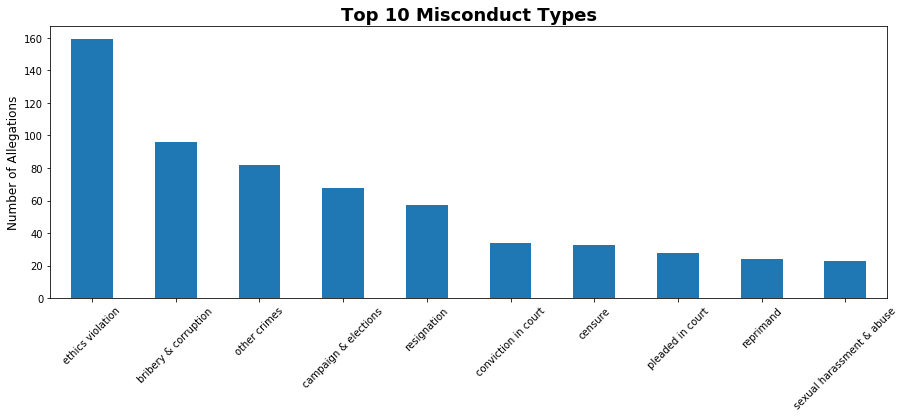

In [158]:
fig,ax = plt.subplots(figsize=(15,5))
# Start from one to skip over "resolved"
top_tags.iloc[1:11].plot(kind='bar',legend=None,rot=45,ax=ax)

ax.set_title('Top 10 Misconduct Types',fontsize=18,fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Number of Allegations',fontsize=12)

plt.show()

In [159]:
# Plot parties with most allegations
top_parties = entries_sql.pivot_table(
    index='party',
    aggfunc='count'
).sort_values('entry_index',ascending=False)
top_parties.head()

,district,entry_index,member,member_name,member_page,paragraph
party,,,,,,
Democrat,211,211,211,211,211,211
Republican,155,155,155,155,155,155
Whig,6,6,6,6,6,6
A (Miscellaneous),4,4,4,4,4,4
Federalist,3,3,3,3,3,3


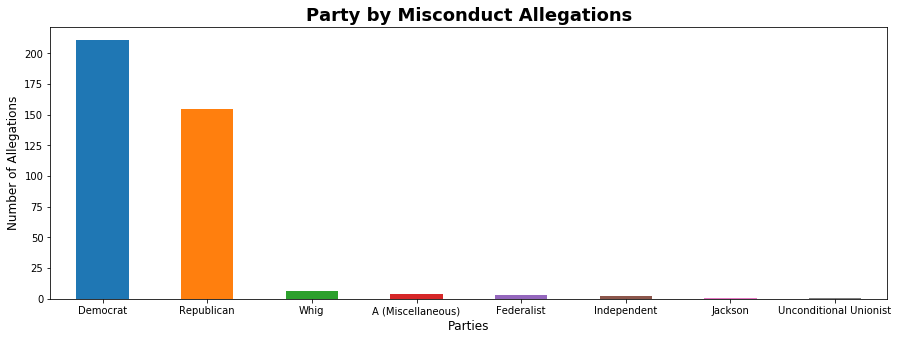

In [160]:
fig,ax = plt.subplots(figsize=(15,5))

top_parties['entry_index'].plot(kind='bar',legend=None,rot=0,ax=ax)
ax.set_title('Party by Misconduct Allegations',fontsize=18,fontweight='bold')
ax.set_xlabel('Parties',fontsize=12)
ax.set_ylabel('Number of Allegations',fontsize=12)

plt.show()

In [161]:
# Plot members with most allegations
top_member = entries_sql.pivot_table(
    index='member_name',
    aggfunc='count'
).sort_values('entry_index',ascending=False)

top_member.head()

,district,entry_index,member,member_page,paragraph,party
member_name,,,,,,
Rep. Newton Gingrich,9,9,9,9,9,9
Rep. Luis Gutiérrez,4,4,4,4,4,4
Rep. Charles Wilson,4,4,4,4,4,4
Rep. Thomas “Tom” DeLay,3,3,3,3,3,3
Rep. John Adams,3,3,3,3,3,3


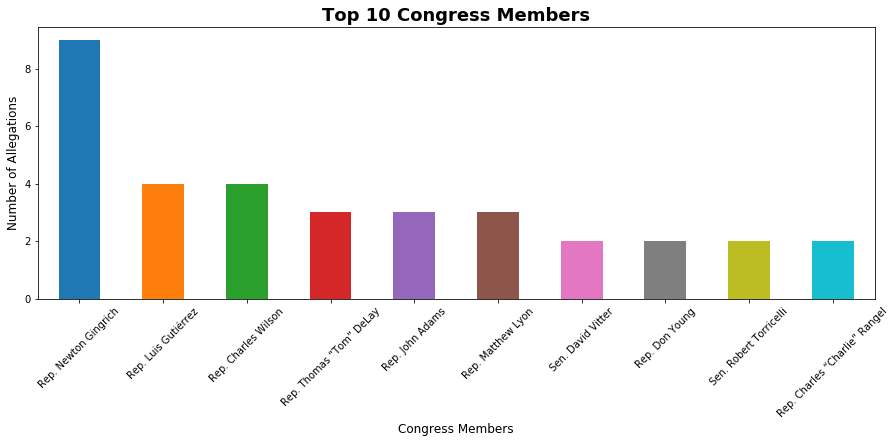

In [162]:
fig,ax = plt.subplots(figsize=(15,5))

top_member['entry_index'].head(10).plot(kind='bar',legend=None,rot=45,ax=ax)
ax.set_title('Top 10 Congress Members',fontsize=18,fontweight='bold')
ax.set_xlabel('Congress Members',fontsize=12)
ax.set_ylabel('Number of Allegations',fontsize=12)

plt.show()